In [156]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings

HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [498]:
sns.set_palette("Dark2")
# sns.set_palette("Pastel2")
plt.rcParams.update({'figure.max_open_warning': 0})

In [494]:
loaded = False

# Load BioBank Components

In [65]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    (biobank_data_no_HLA_alleles, biobank_index,
     med_code_mapping) = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 285 features.
UK BioBank Data Loaded.
Size: 502536 rows x 285 columns
Elapsed time: 50.5796 seconds


Mapping Medical Codes:   0%|          | 0/270 [00:00<?, ? feature/s]

In [67]:
biobank_data = biobank_data.replace('infectious mononucleosis / glandular fever / epstein barr virus (ebv)',
                                    "mononucleosis")
biobank_data = biobank_data.loc[~pd.isnull(biobank_data[constants.HLA_ALLELE_COLUMNS]).any(axis=1)]

In [68]:
def allele_counts(data: pd.DataFrame, allele: str):
    """"""
    allele_loc_cols = [f"{allele[0]}1", f"{allele[0]}2"]
    return np.sum(data[allele_loc_cols] == allele, axis=1)


def get_unique_alleles(data: pd.DataFrame, illness_values):
    """"""
    illness_alleles = data.loc[illness_values][constants.HLA_ALLELE_COLUMNS].values.ravel()
    return np.unique(illness_alleles[~pd.isnull(illness_alleles)])


def get_allele_associations(biobank_data, illness, feature, pbar: bool = False,
                            p_value_threshold: float = 0.05, n_threshold: int = 4):
    """"""

    illness_values = get_illness_value(biobank_data, illness, feature)
    illness_alleles = get_unique_alleles(biobank_data, illness_values)
    
    data = []
    illness_alleles = tqdm(illness_alleles) if pbar else illness_alleles
    for allele in illness_alleles:
        all_allele_zygosity = allele_counts(biobank_data, allele)

        data.append([allele, *calculate_OR(illness_values, all_allele_zygosity > 0), "het",
                     np.count_nonzero(all_allele_zygosity)])
        data.append([allele, *calculate_OR(illness_values, all_allele_zygosity > 1), "homo", 
                     np.count_nonzero(all_allele_zygosity > 1)])

    data = pd.DataFrame(data, columns=["allele", "odds_ratio", "p_value", "N", "lower_bound", "upper_bound",
                                       "zygosity", "N_allele"])
    data["illness"] = illness
    data["hla_loci"] = data["allele"].apply(lambda s: s[0])
    data["disease_frac"] = data["N"] / np.count_nonzero(illness_values)
    data["pop_frac"] = data["N_allele"] / len(biobank_data)
    data = data.drop(columns=["N_allele", "lower_bound", "upper_bound"])

    return data.query(f"p_value < {p_value_threshold} and N > {n_threshold}")

In [363]:
calculate_OR(~biobank_data["cancer_code"].isnull(), biobank_data["zygosity"] != 0)

(1.0115219947607317,
 0.35478132349142383,
 9217,
 0.9911181133183263,
 1.0323459254105134)

# Allele associating

In [364]:
search_data = data_tools.biobank_search(med_code_mapping, biobank_data, ('diabetes')).query("count > 0")
display(search_data)
print(search_data["meaning"].tolist()[:10])

,coding,meaning,code_format,name,count
97,1220,diabetes,6,illness_code,5679
100,1223,type 2 diabetes,6,illness_code,798
99,1222,type 1 diabetes,6,illness_code,173
98,1221,gestational diabetes,6,illness_code,101
320,1521,diabetes insipidus,6,illness_code,1


['diabetes', 'type 2 diabetes', 'type 1 diabetes', 'gestational diabetes', 'diabetes insipidus']


In [114]:
illnesses = [
    "multiple sclerosis",
#     'infectious mononucleosis / glandular fever / epstein barr virus (ebv)',
    "mononucleosis",
    "stomach cancer"
#     "hiv/aids",
#     "type 1 diabetes"
]

cancers = ['hodgkins lymphoma / hodgkins disease', "cervical cancer"]

hodgkins_label = 'hodgkins lymphoma / hodgkins disease'
cancers = ['hodgkins lymphoma / hodgkins disease',
 'larynx/throat cancer',
 'stomach cancer',
 'anal cancer',
 'liver/hepatocellular cancer',
 'cancer of lip/mouth/pharynx/oral cavity',
 'nasal cavity cancer',
 'kaposis sarcoma',
 'cervical cancer']
cancers_and_illnesses = cancers + illnesses

In [ ]:
viral_cancer_types = [
    'hodgkins lymphoma / hodgkins disease', 'larynx/throat cancer', 'stomach cancer',
    'anal cancer', 'liver/hepatocellular cancer',
    'cancer of lip/mouth/pharynx/oral cavity',
    'nasal cavity cancer', 'kaposis sarcoma', "cervical cancer"
]

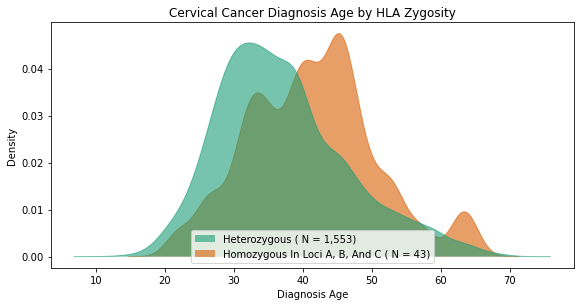

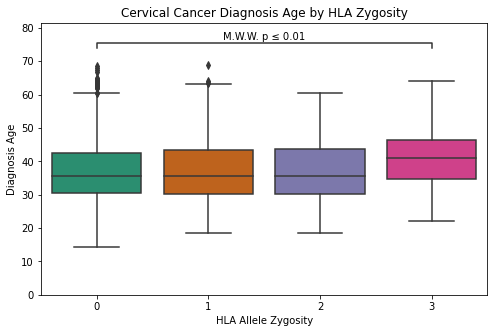

In [572]:
illness = 'cervical cancer'

_, illness_dx_ages = get_illness_value_dx_age(biobank_data, illness, "cancer_code")
illness_values = illness_dx_ages >= 0

illness_dx_ages[~illness_values] = np.nan
no_mid_zyg = biobank_data["zygosity"].isin([0, 3])
z = biobank_data["zygosity"]
zygosity = biobank_data["zygosity"].apply(lambda s: "Homozygous in Loci A, B, and C" if s == 3 else "Heterozygous")

fig, ax = plt.subplots(figsize=(8, 4))
fig.tight_layout()
index = illness_values & no_mid_zyg
kde_plot(illness_dx_ages[index], hue=zygosity[index], ax=ax, add_N_label=True, bw=.2)
ax.set_xlabel("Diagnosis Age")
ax.set_ylabel("Density")
ax.set_title(f"{illness.title()} Diagnosis Age by HLA Zygosity")
plt.show()


fig, ax = plt.subplots(figsize=(8, 5))
index = illness_values & ~pd.isnull(z) & ~pd.isnull(illness_dx_ages)
params = dict(x=z[index].astype(int), y=illness_dx_ages[index])

sns.boxplot(**params)
ax.set_xlabel("HLA Allele Zygosity")
ax.set_ylabel("Diagnosis Age")
ax.set_title(f"{illness.title()} Diagnosis Age by HLA Zygosity")
ax.set_ylim(0, None)
ax.set_xlim(None, 3.5)

pairs = [(0, 3)]

from statannotations.Annotator import Annotator
annotator = Annotator(ax, pairs, data=pd.DataFrame(params), x="x", y="y")
annotator.configure(test='Mann-Whitney', text_format='simple', verbose=-1)
annotator.apply_and_annotate();

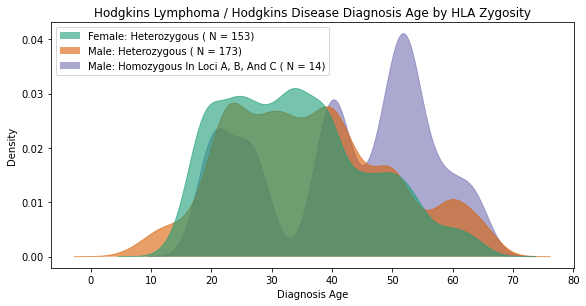

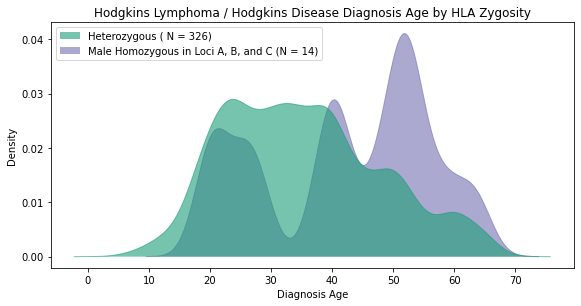

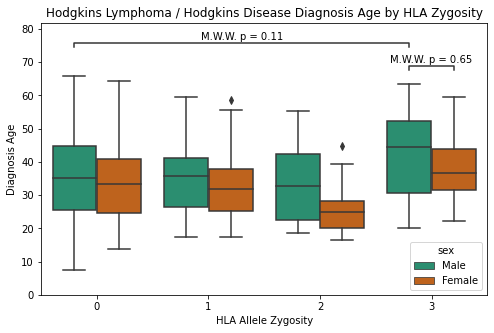

In [529]:
illness = hodgkins_label

_, illness_dx_ages = get_illness_value_dx_age(biobank_data, illness, "cancer_code")
illness_values = illness_dx_ages >= 0

illness_dx_ages[~illness_values] = np.nan
sex = biobank_data["sex"]
no_mid_zyg = biobank_data["zygosity"].isin([0, 3])
z = biobank_data["zygosity"]
zygosity = biobank_data["zygosity"].apply(lambda s: "Homozygous in Loci A, B, and C" if s == 3 else "Heterozygous")
sex_zygosity = biobank_data["sex"] + ": " + zygosity

fig, ax = plt.subplots(figsize=(8, 4))
fig.tight_layout()
index = illness_values & no_mid_zyg & ~((sex == "Female") & (z == 3))
kde_plot(illness_dx_ages[index], hue=sex_zygosity[index], ax=ax, add_N_label=True, bw=.2)
ax.set_xlabel("Diagnosis Age")
ax.set_ylabel("Density")
ax.set_title(f"{illness.title()} Diagnosis Age by HLA Zygosity")
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
fig.tight_layout()

index = illness_values & no_mid_zyg & (z == 0)
kde_plot(illness_dx_ages[index], hue=zygosity[index], ax=ax, add_N_label=True, bw=.2)
plt.plot([],[])
index = illness_values & no_mid_zyg & ((sex == "Male") & (z == 3))
kde_plot(illness_dx_ages[index], ax=ax, add_N_label=True, bw=.2, zorder=-1,
         label="Male Homozygous in Loci A, B, and C")
ax.set_xlabel("Diagnosis Age")
ax.set_ylabel("Density")
ax.set_title(f"{illness.title()} Diagnosis Age by HLA Zygosity")
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
index = illness_values & ~pd.isnull(z) & ~pd.isnull(illness_dx_ages) & ~pd.isnull(sex)
params = dict(x=z[index].astype(int), y=illness_dx_ages[index], hue=sex[index])

sns.boxplot(**params)
ax.set_xlabel("HLA Allele Zygosity")
ax.set_ylabel("Diagnosis Age")
ax.set_title(f"{illness.title()} Diagnosis Age by HLA Zygosity")
ax.set_ylim(0, None)
ax.set_xlim(None, 3.5)

pairs = [((3, "Female"), (3, "Male")),((0, "Male"), (3, "Male"))]

from statannotations.Annotator import Annotator
annotator = Annotator(ax, pairs, data=pd.DataFrame(params), x="x", y="y", hue="hue")
annotator.configure(test='Mann-Whitney', text_format='simple', verbose=-1)
annotator.apply_and_annotate();

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))


kde_plot(illness_dx_ages, clip=[0, None], label="No alleles", ax=ax, add_N_label=True, bw=.05)

kde_plot(cervical_cancer_dx_ages[no_alleles], clip=[0, None], label="No alleles", ax=ax, add_N_label=True, bw=.05)

A*02:01 0.9153968685998831 36.768149171270714
B*44:02 0.9325406950043374 37.54623525498891
C*07:02 0.8990516757565727 36.75688527508091
no alleles 0.8726333907056799 37.94080860585198


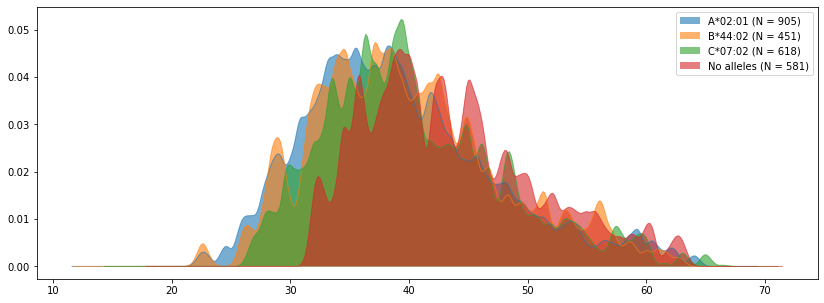

In [344]:
no_alleles = cervical_cancer

fig, ax = plt.subplots(figsize=(14, 5))
for allele in alleles:
    has_allele = biobank_data[constants.HLA_ALLELE_COLUMNS].isin([allele]).any(axis=1)
    no_alleles = no_alleles & ~has_allele
#     print(allele, calculate_OR(cervical_cancer, has_allele))
#     print(allele, calculate_OR(dx_before_30[cervical_cancer], has_allele[cervical_cancer]))

    ages = cervical_cancer_dx_ages[has_allele & cervical_cancer]
    kde_plot(ages, clip=[0, None], label=allele, ax=ax, add_N_label=True, bw=.05)
    print(allele, (biobank_data["ethnic_background"][has_allele] == "British").mean(), np.mean(ages))

kde_plot(cervical_cancer_dx_ages[no_alleles], clip=[0, None], label="No alleles", ax=ax, add_N_label=True, bw=.05)
print("no alleles", (biobank_data["ethnic_background"][no_alleles] == "British").mean(),
      np.mean(cervical_cancer_dx_ages[no_alleles]))

(1.3323072883176843, 0.005972779550863979, 324, 1.1197972406771053, 1.5851465301263914)
(1.1852600124670938, 0.0006145060974267018, 1350, 1.0922023667002192, 1.2862463404083497)


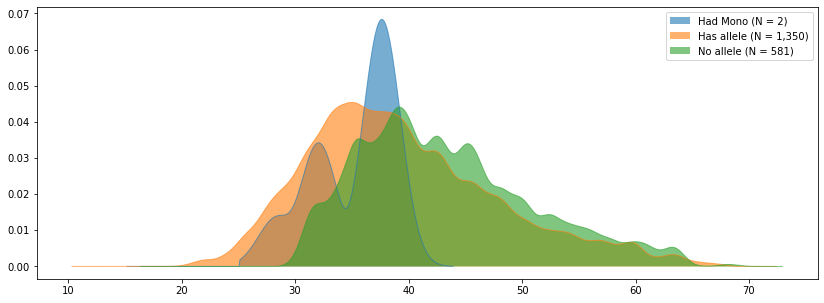

In [326]:
had_mono = get_illness_value(biobank_data, "mononucleosis", "illness_code")

_, cervical_cancer_dx_ages = get_illness_value_dx_age(biobank_data, "cervical cancer", "cancer_code")
dx_before_30 = (cervical_cancer_dx_ages < 30) & (cervical_cancer_dx_ages >= 0)
cervical_cancer_dx_ages[cervical_cancer_dx_ages < 0] = np.nan

cervical_cancer = cervical_cancer_dx_ages >= 0

alleles = ["A*02:01", "B*44:02", "C*07:02"]

has_allele = biobank_data[constants.HLA_ALLELE_COLUMNS].isin(alleles).any(axis=1)

fig, ax = plt.subplots(figsize=(14, 5))
kde_plot(cervical_cancer_dx_ages[had_mono & cervical_cancer], clip=[0, None],
         label="Had Mono", ax=ax, add_N_label=True)
kde_plot(cervical_cancer_dx_ages[has_allele & cervical_cancer], clip=[0, None],
         label="Has allele", ax=ax, add_N_label=True, bw=.1)
kde_plot(cervical_cancer_dx_ages[~has_allele & cervical_cancer], clip=[0, None],
         label="No allele", ax=ax, add_N_label=True, bw=.1)

print(calculate_OR(dx_before_30, has_allele))
print(calculate_OR(cervical_cancer, has_allele))

# Intermission Risk Alleles

hodgkins lymphoma / hodgkins disease


,ethnic_background,Odds Ratio,pvalue,N,5%,95%
12,Indian,0.260859,0.000073,6,0.133096,0.511263
0,African,0.311612,0.010196,4,0.136724,0.710203
9,Caribbean,0.640676,0.178008,11,0.389371,1.054178
10,Chinese,0.667111,0.539580,4,0.292535,1.521314
15,Other ethnic group,0.747912,0.394945,13,0.472890,1.182878
13,Irish,1.005547,0.943131,51,0.795848,1.270500
4,Any other white background,1.134083,0.303594,71,0.929137,1.384236
8,British,1.197510,0.016245,1748,1.057126,1.356536
17,Prefer not to answer,1.273930,0.422820,8,0.710266,2.284917
3,Any other mixed background,1.775258,0.124876,7,0.950211,3.316673


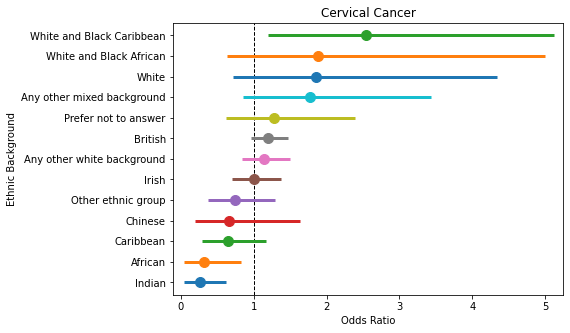

In [169]:
illness = hodgkins_label
illness = "cervical cancer"

illness_values = get_illness_value(biobank_data, illness, "cancer_code")

values = []
for background in np.unique(biobank_data["ethnic_background"].dropna()):
    background_values = biobank_data["ethnic_background"] == background
    OR, pvalue, N, low, high = calculate_OR(illness_values, background_values)
    values.append([background, OR, pvalue, N, low, high])
    
df = pd.DataFrame(values, columns=["ethnic_background", "Odds Ratio", "pvalue", "N", "5%", "95%"])
print(hodgkins_label)
df = df.query("N > 1").sort_values("Odds Ratio")
display(df)

fig, ax = plt.subplots(figsize=(7, 5))
ax.axvline(1, ls='--', linewidth=1, color='black')
n = 0
x_s, x_labels = [], []
for index, row in df.iterrows():
    x = [n, n]
    x_s.append(n)
    x_labels.append(row["ethnic_background"])
    y = [row["5%"], row["95%"]]
    g = ax.plot(y, x, "_-", markersize = 15, markeredgewidth= 3, linewidth = 3)

    x = [n]
    y = [row["Odds Ratio"]]
    ax.plot(y, x, "o", markersize = 10, color=g[0].get_color())
    n += 1

ax.set_ylabel("Ethnic Background")
ax.set_xlabel("Odds Ratio")
ax.set_title(illness.title())
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax.set_yticks(x_s)
    ax.set_yticklabels(x_labels, rotation=0)

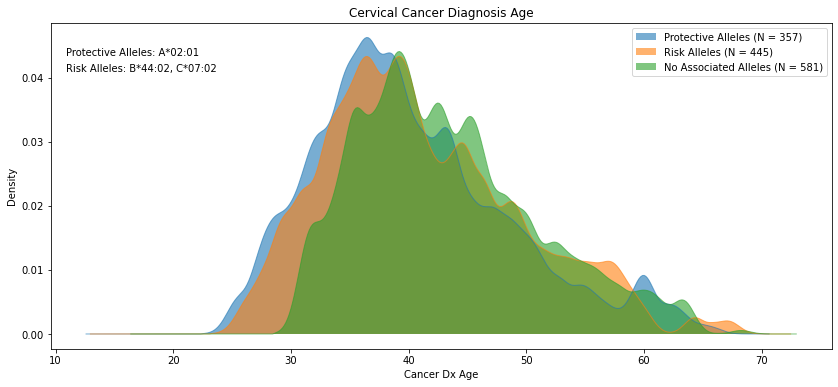

In [261]:
illness = hodgkins_label
illness = "cervical cancer"

_, illness_dx_ages = get_illness_value_dx_age(biobank_data, illness, "cancer_code")

if illness == "cervical cancer":
    protective_alleles = ["A*02:01"]
    risk_alleles = ["B*44:02", "C*07:02"]

else:
    protective_alleles = ["A*02:01"]
    risk_alleles = ["A*01:01", "B*44:02"]

illness_values = illness_dx_ages >= 0

fig, ax = plt.subplots(figsize=(14, 6))

has_protective_allele = biobank_data[constants.HLA_ALLELE_COLUMNS].isin(protective_alleles).any(axis=1)
has_risk_allele = biobank_data[constants.HLA_ALLELE_COLUMNS].isin(risk_alleles).any(axis=1)

index = illness_values & has_protective_allele & ~ has_risk_allele
kde_plot(illness_dx_ages[index], clip=[0, None], bw=0.1,
         ax=ax, label=f"Protective Alleles (N = {np.count_nonzero(index):,})")

index = illness_values & has_risk_allele & ~ has_protective_allele
kde_plot(illness_dx_ages[index], clip=[0, None], bw=0.1,
         ax=ax, label=f"Risk Alleles (N = {np.count_nonzero(index):,})")
index = illness_values & ~has_risk_allele & ~has_protective_allele
kde_plot(illness_dx_ages[index], clip=[0, None], bw=0.1,
         ax=ax, label=f"No Associated Alleles (N = {np.count_nonzero(index):,})")
ax.set_xlabel("Cancer Dx Age")
ax.set_ylabel("Density")
ax.set_title(illness.title() + " Diagnosis Age")

ax.text(0.02, .9, f"Protective Alleles: {', '.join(protective_alleles)}", transform = ax.transAxes)
ax.text(0.02, .85, f"Risk Alleles: {', '.join(risk_alleles)}", transform = ax.transAxes)
plt.show()

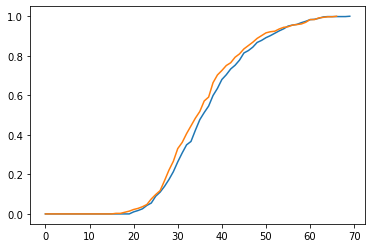

In [264]:
no_alleles_bins = np.bincount(illness_dx_ages[illness_values & ~has_risk_allele & ~has_protective_allele].astype(int))
alleles_bins = np.bincount(illness_dx_ages[illness_values & has_protective_allele & ~has_risk_allele].astype(int))
no_alleles_bins = no_alleles_bins / np.sum(no_alleles_bins)
alleles_bins = alleles_bins / np.sum(alleles_bins)

plt.plot(np.cumsum(no_alleles_bins))
plt.plot(np.cumsum(alleles_bins))

In [248]:
if illness != "cervical cancer":
    sex = biobank_data["sex"] == "Female"

    fig, ax = plt.subplots(figsize=(14, 6))
    index = illness_values & has_risk_allele & ~has_protective_allele & sex
    kde_plot(illness_dx_ages[index], clip=[0, None], bw=0.2,
             ax=ax, label=f"Female\nRisk Alleles (N = {np.count_nonzero(index):,})")

    index = illness_values & has_risk_allele & ~has_protective_allele & ~sex
    kde_plot(illness_dx_ages[index], clip=[0, None], bw=0.2,
             ax=ax, label=f"Male\nRisk Alleles (N = {np.count_nonzero(index):,})")
    ax.set_xlabel("Cancer Dx Age")
    ax.set_ylabel("Density")
    ax.set_title(illness.title() + " Diagnosis Age")

    ax.text(0.02, .9, f"Protective Alleles: {', '.join(protective_alleles)}", transform = ax.transAxes)
    ax.text(0.02, .85, f"Risk Alleles: {', '.join(risk_alleles)}", transform = ax.transAxes)
    plt.show()

    fig, ax = plt.subplots(figsize=(14, 6))
    index = illness_values & ~has_risk_allele & has_protective_allele & sex
    kde_plot(illness_dx_ages[index], clip=[0, None], bw=0.2,
             ax=ax, label=f"Female\nProtective Alleles (N = {np.count_nonzero(index):,})")

    index = illness_values & ~has_risk_allele & has_protective_allele & ~sex
    kde_plot(illness_dx_ages[index], clip=[0, None], bw=0.2,
             ax=ax, label=f"Male\nProtective Alleles (N = {np.count_nonzero(index):,})")
    ax.set_xlabel("Cancer Dx Age")
    ax.set_ylabel("Density")
    ax.set_title(illness.title() + " Diagnosis Age")

    ax.text(0.02, .9, f"Protective Alleles: {', '.join(protective_alleles)}", transform = ax.transAxes)
    ax.text(0.02, .85, f"Risk Alleles: {', '.join(risk_alleles)}", transform = ax.transAxes)
    plt.show()


    fig, ax = plt.subplots(figsize=(14, 6))
    index = illness_values & sex
    kde_plot(illness_dx_ages[index], clip=[0, None], bw=0.2,
             ax=ax, label=f"Female (N = {np.count_nonzero(index):,})")

    index = illness_values & ~sex
    kde_plot(illness_dx_ages[index], clip=[0, None], bw=0.2,
             ax=ax, label=f"Male (N = {np.count_nonzero(index):,})")
    ax.set_xlabel("Cancer Dx Age")
    ax.set_ylabel("Density")
    ax.set_title(illness.title() + " Diagnosis Age")
    plt.show()

In [9]:
data = []
for illness in tqdm(cancers_and_illnesses):
    feature = "cancer_code" if illness in cancers else "illness_code"
    data.append(get_allele_associations(biobank_data, illness, feature, pbar=False))
    
data = pd.concat(data)

  0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
illness_value_data = {}
for illness in tqdm(cancers_and_illnesses):
    feature = "cancer_code" if illness in cancers else "illness_code"
    illness_value_data[illness] = get_illness_value(biobank_data, illness, feature).values

  0%|          | 0/12 [00:00<?, ?it/s]

In [71]:
alleles_of_interest = ["A*02:01", "A*01:01"]
allele = alleles_of_interest[-1]

# data = biobank_data

all_allele_zygosity = allele_counts(biobank_data, allele)

for illness, illness_values in illness_value_data.items():
    print(illness, calculate_OR(illness_values, all_allele_zygosity > 1))

hodgkins lymphoma / hodgkins disease (1.8219489580243746, 0.0034458672141722702, 29, 1.3284155080309745, 2.4988401487170115)
larynx/throat cancer (0.9494533179597759, 1.0, 12, 0.5855417656934702, 1.5395342498194067)
stomach cancer (1.2736437193261705, 0.4212288755719716, 8, 0.702239351710783, 2.309993479896994)
anal cancer (0.8103998443260817, 1.0, 2, 0.24885789825775634, 2.6390478754405704)
liver/hepatocellular cancer (0.7597017836659191, 0.6909001175342229, 5, 0.3602659263419113, 1.6020021820143944)
cancer of lip/mouth/pharynx/oral cavity (1.3110641551152689, 0.44106336148920783, 5, 0.6171264293706031, 2.7853113025497547)
nasal cavity cancer (1.1886394776887474, 0.686981898607539, 2, 0.36207268635907447, 3.9021551780876784)
kaposis sarcoma (0.0, 1.0, 0, 0.0, nan)
cervical cancer (1.0596991144495322, 0.6252486209102599, 74, 0.8716335276493894, 1.2883421501620222)
multiple sclerosis (1.4947505342837235, 0.000418649943818163, 90, 1.2502653328215712, 1.7870439986520343)
mononucleosis (1.

In [72]:
het_data = data.query("zygosity == 'het'")
homo_data = data.query("zygosity == 'homo'")
het_data = het_data.loc[het_data.duplicated(["allele"], keep=False).values].sort_values("allele")
homo_data = homo_data.loc[homo_data.duplicated(["allele"], keep=False).values].sort_values("allele")

In [73]:
df["illness"].iloc[0]

'hodgkins lymphoma'

In [74]:
data.loc[data.duplicated(["allele"], keep=False).values].sort_values("allele")

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
1,A*01:01,1.821949,0.003446,29,homo,hodgkins lymphoma / hodgkins disease,A,0.063736,0.036044
1,A*01:01,1.475659,0.043049,30,homo,mononucleosis,A,0.052265,0.036044
1,A*01:01,1.494751,0.000419,90,homo,multiple sclerosis,A,0.052848,0.036044
0,A*01:01,1.164462,0.002683,636,het,multiple sclerosis,A,0.373459,0.338693
2,A*02:01,0.765187,0.001662,226,het,mononucleosis,A,0.393728,0.459007
...,...,...,...,...,...,...,...,...,...
196,C*15:02,1.750046,0.004951,30,het,hodgkins lymphoma / hodgkins disease,C,0.065934,0.038797
166,C*15:02,2.077783,0.017900,14,het,liver/hepatocellular cancer,C,0.077348,0.038797
236,C*16:01,0.757667,0.004013,112,het,multiple sclerosis,C,0.065766,0.084946
122,C*16:01,2.793406,0.001533,14,het,anal cancer,C,0.205882,0.084946


In [75]:
het_data

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
2,A*02:01,0.765187,1.661717e-03,226,het,mononucleosis,A,0.393728,0.459007
4,A*02:01,0.672124,1.382886e-15,619,het,multiple sclerosis,A,0.363476,0.459007
40,A*31:01,1.485639,1.779542e-02,43,het,mononucleosis,A,0.074913,0.051718
48,A*31:01,1.273555,1.022257e-02,126,het,cervical cancer,A,0.064882,0.051718
70,B*07:02,1.600234,1.115710e-19,620,het,multiple sclerosis,B,0.364063,0.263838
74,B*07:02,1.218618,7.838020e-05,590,het,cervical cancer,B,0.303811,0.263838
48,B*08:01,1.471598,1.920489e-02,59,het,stomach cancer,B,0.335227,0.255245
48,B*08:01,1.471598,1.920489e-02,59,het,stomach cancer,B,0.335227,0.255245
38,B*08:01,0.445050,1.786974e-02,9,het,anal cancer,B,0.132353,0.255245
76,B*13:02,0.692474,1.040103e-02,47,het,multiple sclerosis,B,0.027598,0.039331


(<Figure size 1512x540 with 1 Axes>, <AxesSubplot:>)

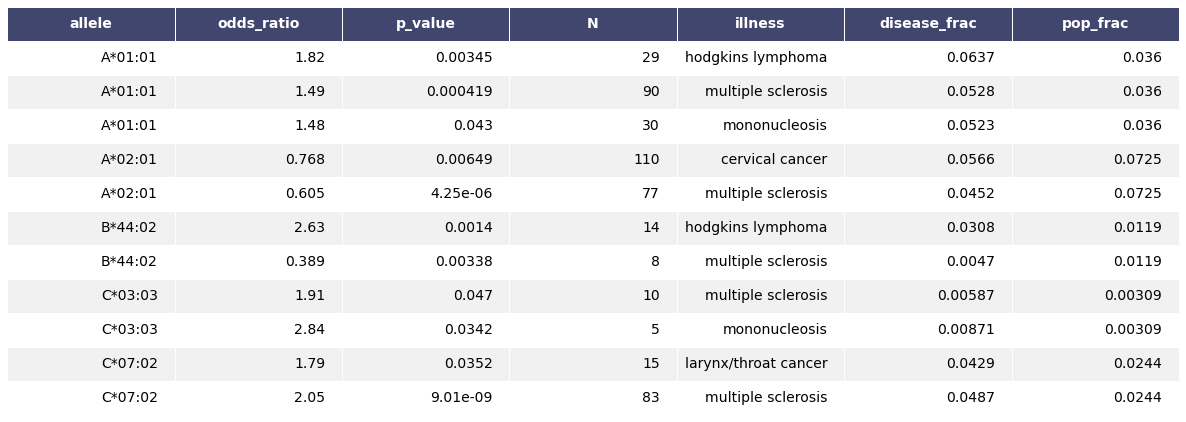

In [76]:
homo_data

df = homo_data.drop(columns=["zygosity", "hla_loci"]).replace('hodgkins lymphoma / hodgkins disease', "hodgkins lymphoma")
for column in df.columns:
    df[column] = df[column].apply(lambda s: f"{s:.3}" if isinstance(s, float) else s)
render_mpl_table(df)

(<Figure size 1512x360 with 1 Axes>, <AxesSubplot:>)

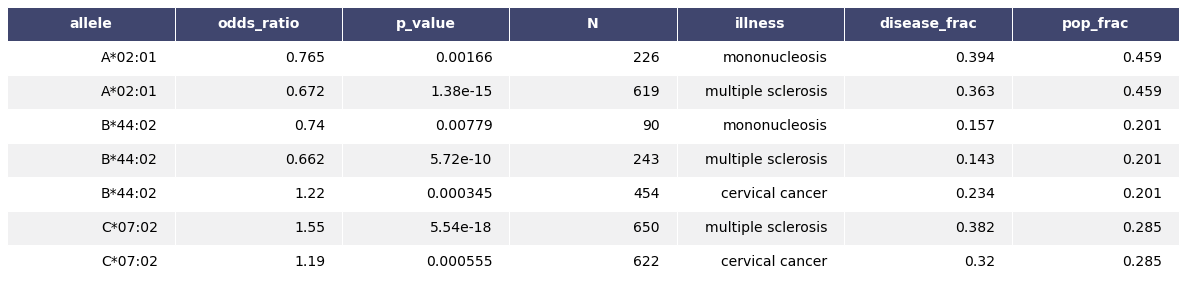

In [77]:
df = het_data.loc[het_data["allele"].isin(homo_data["allele"])].drop(columns=["zygosity", "hla_loci"])
for column in df.columns:
    df[column] = df[column].apply(lambda s: f"{s:.3}" if isinstance(s, float) else s)
render_mpl_table(df)
# df

(-5.0, 5.0)

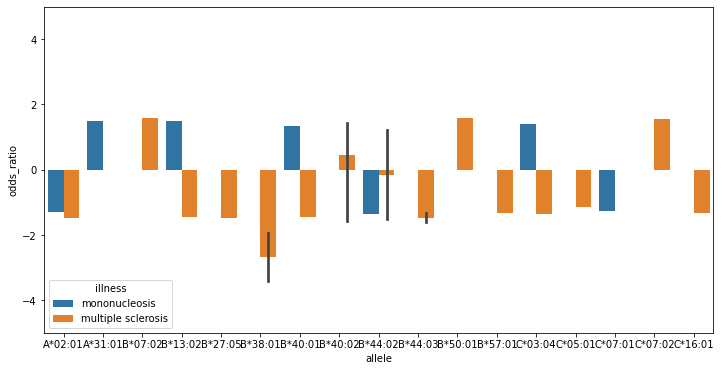

In [78]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=het_data.loc[het_data["illness"].isin(["multiple sclerosis", "mononucleosis"])], x="allele",
            y=het_data["odds_ratio"].apply(lambda s: s if s > 1 else -1 / s), hue="illness", ax=ax, dodge=True)
ax.set_ylim(-5, 5)

In [79]:
data.query("illness == 'hodgkins lymphoma / hodgkins disease' and zygosity == 'homo'")

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
1,A*01:01,1.821949,0.003446,29,homo,hodgkins lymphoma / hodgkins disease,A,0.063736,0.036044
127,B*44:02,2.629084,0.001396,14,homo,hodgkins lymphoma / hodgkins disease,B,0.030769,0.011948


In [80]:
data.query("illness == 'cervical cancer'")

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
5,A*02:01,0.767521,0.006492,110,homo,cervical cancer,A,0.056643,0.072491
48,A*31:01,1.273555,0.010223,126,het,cervical cancer,A,0.064882,0.051718
74,B*07:02,1.218618,0.000078,590,het,cervical cancer,B,0.303811,0.263838
88,B*15:01,0.785688,0.001507,185,het,cervical cancer,B,0.095263,0.118085
116,B*35:01,0.840134,0.034166,160,het,cervical cancer,B,0.082389,0.096497
130,B*38:01,0.516246,0.001778,20,het,cervical cancer,B,0.010299,0.019721
154,B*44:02,1.216263,0.000345,454,het,cervical cancer,B,0.233780,0.200680
184,B*55:01,1.411505,0.001694,96,het,cervical cancer,B,0.049434,0.035589
214,C*04:01,0.844572,0.008292,285,het,cervical cancer,C,0.146756,0.169105
215,C*04:01,0.466652,0.026870,8,homo,cervical cancer,C,0.004119,0.008768


In [81]:
data.query("illness == 'mononucleosis'")

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
1,A*01:01,1.475659,0.043049,30,homo,mononucleosis,A,0.052265,0.036044
2,A*02:01,0.765187,0.001662,226,het,mononucleosis,A,0.393728,0.459007
40,A*31:01,1.485639,0.017795,43,het,mononucleosis,A,0.074913,0.051718
64,B*13:02,1.490734,0.031013,33,het,mononucleosis,B,0.057491,0.039331
71,B*15:01,2.604495,0.030842,6,homo,mononucleosis,B,0.010453,0.004047
102,B*40:01,1.344708,0.019398,77,het,mononucleosis,B,0.134146,0.103348
110,B*44:02,0.740413,0.007792,90,het,mononucleosis,B,0.156794,0.200680
149,C*03:03,2.840621,0.034222,5,homo,mononucleosis,C,0.008711,0.003091
150,C*03:04,1.405768,0.001739,112,het,mononucleosis,C,0.195122,0.147141
156,C*06:02,1.288766,0.015062,122,het,mononucleosis,C,0.212544,0.173213


In [82]:
data.loc[data["allele"].isin(["A*01:01", "B*44:02"])].sort_values(["allele", "illness"]).reset_index(drop=True)

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
0,A*01:01,1.821949,3.445867e-03,29,homo,hodgkins lymphoma / hodgkins disease,A,0.063736,0.036044
1,A*01:01,1.475659,4.304913e-02,30,homo,mononucleosis,A,0.052265,0.036044
2,A*01:01,1.164462,2.683448e-03,636,het,multiple sclerosis,A,0.373459,0.338693
3,A*01:01,1.494751,4.186499e-04,90,homo,multiple sclerosis,A,0.052848,0.036044
4,B*44:02,1.216263,3.445690e-04,454,het,cervical cancer,B,0.233780,0.200680
5,B*44:02,2.629084,1.396498e-03,14,homo,hodgkins lymphoma / hodgkins disease,B,0.030769,0.011948
6,B*44:02,0.740413,7.792087e-03,90,het,mononucleosis,B,0.156794,0.200680
7,B*44:02,0.662096,5.717538e-10,243,het,multiple sclerosis,B,0.142689,0.200680
8,B*44:02,0.389454,3.381989e-03,8,homo,multiple sclerosis,B,0.004698,0.011948


In [83]:
data.loc[data["allele"].isin(["C*07:01", "C*07:02"])].sort_values(["allele", "illness"]).reset_index(drop=True)

,allele,odds_ratio,p_value,N,zygosity,illness,hla_loci,disease_frac,pop_frac
0,C*07:01,0.516484,3.554638e-02,13,het,anal cancer,C,0.191176,0.313942
1,C*07:01,0.793977,1.502478e-02,153,het,mononucleosis,C,0.266551,0.313942
2,C*07:01,1.621068,8.104842e-05,81,homo,multiple sclerosis,C,0.047563,0.029947
3,C*07:01,1.443325,1.843906e-02,70,het,stomach cancer,C,0.397727,0.313942
4,C*07:01,1.443325,1.843906e-02,70,het,stomach cancer,C,0.397727,0.313942
5,C*07:02,1.185056,5.547149e-04,622,het,cervical cancer,C,0.320288,0.284645
6,C*07:02,1.790484,3.519386e-02,15,homo,larynx/throat cancer,C,0.042857,0.024411
7,C*07:02,1.553919,5.538207e-18,650,het,multiple sclerosis,C,0.381679,0.284645
8,C*07:02,2.054949,9.013404e-09,83,homo,multiple sclerosis,C,0.048738,0.024411


# Logistic Regression Attempts

In [230]:
all_alleles = sorted(np.unique(biobank_data[constants.HLA_ALLELE_COLUMNS].values))

In [396]:
all_alleles = sorted(data["allele"].unique())
# all_alleles = ["A*01:01", "A*02:01"]

In [397]:
X_full = []
for allele in tqdm(all_alleles):
    X_full.append((biobank_data[constants.HLA_ALLELE_COLUMNS] == allele).sum(axis=1).values)
X_full = np.array(X_full).T

  0%|          | 0/50 [00:00<?, ?it/s]

In [382]:
y_full = []
for illness in tqdm(cancers_and_illnesses):
    feature = "cancer_code" if illness in cancers else "illness_code"
    y_full.append(get_illness_value(biobank_data, illness, feature).values * 1)
y_full = np.array(y_full).T
y_full = y_full[:, -1]

  0%|          | 0/4 [00:00<?, ?it/s]

In [408]:
X_control = X_full[~y_full]
n_disease = np.count_nonzero(y_full)
indices = np.random.choice(np.arange(len(X_control)), n_disease)

X = np.vstack([X_control[indices], X_full[y_full == 1]])
y = np.array([0] * n_disease + [1] * n_disease)
X = (X > 0) * 1

In [409]:
from sklearn.linear_model import LogisticRegression as LR

clf = LR(random_state=0, penalty="l1", solver="saga", warm_start=True).fit(X, y)

C:\Users\Cole\Miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [410]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [411]:
clf.score(X, y)

0.9991289198606271

In [412]:
for allele, OR in zip(all_alleles, np.exp(clf.coef_).ravel()):
    if OR != 1:
        print(allele, OR)

A*01:01 1.0795385638827473
B*35:01 0.04042820740800643
C*06:02 0.1087154958849661
C*17:01 0.00018207682224156163
